# SocialProphet - Phase 2: Time Series Forecasting

This notebook implements and evaluates the forecasting pipeline:
1. Load preprocessed data
2. Stationarity analysis
3. Train individual models (Prophet, SARIMA, LSTM)
4. Ensemble predictions
5. Evaluate metrics
6. Visualizations

**Target Metrics:**
- MAPE < 15%
- RMSE < 15% of mean
- R² > 0.70

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.utils.config import Config
from src.forecasting.stationarity import StationarityAnalyzer
from src.forecasting.prophet_model import ProphetForecaster
from src.forecasting.sarima_model import SARIMAForecaster
from src.forecasting.lstm_model import LSTMForecaster
from src.forecasting.ensemble import EnsembleForecaster
from src.evaluation.metrics import ForecastMetrics
from src.evaluation.visualizer import Visualizer

print("Imports successful!")
print(f"Project root: {project_root}")

Imports successful!
Project root: s:\Projects\SocialProphet


## 1. Load Data

In [2]:
# Load train and test data
train_df = pd.read_csv(Config.PROCESSED_DATA_DIR / "train_data.csv", parse_dates=['ds'])
test_df = pd.read_csv(Config.PROCESSED_DATA_DIR / "test_data.csv", parse_dates=['ds'])

# Load Prophet-format data
train_prophet = pd.read_csv(Config.PROCESSED_DATA_DIR / "train_prophet.csv", parse_dates=['ds'])
test_prophet = pd.read_csv(Config.PROCESSED_DATA_DIR / "test_prophet.csv", parse_dates=['ds'])

print(f"Training data: {len(train_df)} rows, {len(train_df.columns)} columns")
print(f"Test data: {len(test_df)} rows")
print(f"\nDate range: {train_df['ds'].min()} to {test_df['ds'].max()}")
print(f"\nTarget variable (y):")
print(f"  Log scale range: [{train_df['y'].min():.2f}, {train_df['y'].max():.2f}]")
print(f"  Original scale range: [{train_df['y_raw'].min():,.0f}, {train_df['y_raw'].max():,.0f}]")

Training data: 292 rows, 30 columns
Test data: 74 rows

Date range: 2024-11-19 00:00:00 to 2025-11-19 00:00:00

Target variable (y):
  Log scale range: [9.72, 10.83]
  Original scale range: [16,637, 50,695]


In [3]:
# Preview data
train_df.head()

,ds,engagement_sum,engagement_mean,post_count,likes_sum,comments_sum,shares_sum,y_raw,y,day_of_week,...,y_lag_14,y_lag_30,y_rolling_mean_7,y_rolling_std_7,y_rolling_mean_14,y_rolling_std_14,y_rolling_mean_30,y_rolling_std_30,y_pct_change_1,y_pct_change_7
0,2024-11-19,27669,354.730769,78,22588,612,1136,27669,10.228104,1,...,0.0,0.0,10.228104,0.000000,10.228104,0.000000,10.228104,0.000000,0.000000,0.0
1,2024-11-20,37000,381.443299,97,29983,912,1479,37000,10.518700,2,...,0.0,0.0,10.373402,0.205483,10.373402,0.205483,10.373402,0.205483,0.028412,0.0
2,2024-11-21,25477,299.729412,85,20678,592,1020,25477,10.145571,3,...,0.0,0.0,10.297458,0.195995,10.297458,0.195995,10.297458,0.195995,-0.035473,0.0
3,2024-11-22,21457,306.528571,70,17554,507,862,21457,9.973853,4,...,0.0,0.0,10.216557,0.227573,10.216557,0.227573,10.216557,0.227573,-0.016925,0.0
4,2024-11-23,29896,335.910112,89,24353,758,1279,29896,10.305513,5,...,0.0,0.0,10.234348,0.201059,10.234348,0.201059,10.234348,0.201059,0.033253,0.0


In [4]:
# Feature columns for LSTM
feature_cols = [col for col in train_df.columns if col not in ['ds', 'y', 'y_raw']]
print(f"Available features ({len(feature_cols)}): {feature_cols}")

Available features (27): ['engagement_sum', 'engagement_mean', 'post_count', 'likes_sum', 'comments_sum', 'shares_sum', 'day_of_week', 'day_of_month', 'month', 'week_of_year', 'is_weekend', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'y_lag_1', 'y_lag_7', 'y_lag_14', 'y_lag_30', 'y_rolling_mean_7', 'y_rolling_std_7', 'y_rolling_mean_14', 'y_rolling_std_14', 'y_rolling_mean_30', 'y_rolling_std_30', 'y_pct_change_1', 'y_pct_change_7']


## 2. Stationarity Analysis

Before fitting SARIMA, we verify time series stationarity using:
- **ADF Test**: Null hypothesis = non-stationary (reject if p < 0.05)
- **KPSS Test**: Null hypothesis = stationary (reject if p < 0.05)

In [5]:
# Analyze stationarity
analyzer = StationarityAnalyzer()
stationarity_result = analyzer.analyze(train_df['y'], name="engagement_log")

print("\n" + "="*60)
print("STATIONARITY ANALYSIS RESULTS")
print("="*60)
print(f"\nSeries: {stationarity_result['series_name']}")
print(f"Observations: {stationarity_result['n_observations']}")

print(f"\nADF Test:")
print(f"  Statistic: {stationarity_result['adf_test']['test_statistic']:.4f}")
print(f"  P-value: {stationarity_result['adf_test']['p_value']:.4f}")
print(f"  Is Stationary: {stationarity_result['adf_test']['is_stationary']}")

print(f"\nKPSS Test:")
print(f"  Statistic: {stationarity_result['kpss_test']['test_statistic']:.4f}")
print(f"  P-value: {stationarity_result['kpss_test']['p_value']:.4f}")
print(f"  Is Stationary: {stationarity_result['kpss_test']['is_stationary']}")

print(f"\nRecommendation: {stationarity_result['recommendation']}")


Analyzing stationarity for: engagement_log

ADF Test:
  Statistic: -16.5982
  P-value: 0.0000
  Stationary: True

KPSS Test:
  Statistic: 0.1538
  P-value: 0.1000
  Stationary: True

Combined Result: STATIONARY
Recommendation: Series is stationary. No differencing needed (d=0).
Suggested differencing order (d): 1

STATIONARITY ANALYSIS RESULTS

Series: engagement_log
Observations: 292

ADF Test:
  Statistic: -16.5982
  P-value: 0.0000
  Is Stationary: True

KPSS Test:
  Statistic: 0.1538
  P-value: 0.1000
  Is Stationary: True

Recommendation: Series is stationary. No differencing needed (d=0).


In [6]:
# Differencing analysis
diff_result = analyzer.differencing_analysis(train_df['y'], max_d=2)
print(f"\nRecommended differencing order: d={diff_result['optimal_d']}")

# Save stationarity report
analyzer.save_report()


Recommended differencing order: d=1

Stationarity report saved: s:\Projects\SocialProphet\data\processed\stationarity_report.json


WindowsPath('s:/Projects/SocialProphet/data/processed/stationarity_report.json')

## 3. Train Individual Models

### 3.1 Prophet Model

In [7]:
# Train Prophet
print("Training Prophet model...")
prophet_forecaster = ProphetForecaster(params={
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': False  # Not enough data for yearly
})
prophet_forecaster.fit(train_prophet)
print("Prophet training complete!")

# Predict on test set
prophet_preds = prophet_forecaster.predict_test(test_prophet)
print(f"\nProphet predictions: {len(prophet_preds)} rows")

Training Prophet model...
Training Prophet on 292 observations...
  Date range: 2024-11-19 00:00:00 to 2025-09-06 00:00:00
  y (log) range: [9.72, 10.83]
Prophet model fitted successfully!
Prophet training complete!

Prophet predictions: 74 rows


In [8]:
# Prophet evaluation
prophet_eval = prophet_forecaster.evaluate(test_prophet)
print("\nProphet Metrics (Original Scale):")
for metric, value in prophet_eval['metrics_original_scale'].items():
    print(f"  {metric}: {value:.4f}")


Prophet Evaluation Results (Original Scale):
  MAPE: 12.43%
  RMSE: 4,584.90
  MAE: 3,639.66
  R²: -0.2494

Prophet Metrics (Original Scale):
  mape: 12.4344
  rmse: 4584.9034
  mae: 3639.6623
  r2: -0.2494


### 3.2 SARIMA Model

In [9]:
# Train SARIMA with auto order selection
print("Training SARIMA model (auto-selecting order)...")
sarima_forecaster = SARIMAForecaster()

# Auto-select order
order, seasonal_order = sarima_forecaster.auto_select_order(
    train_df['y'],
    seasonal=True,
    m=7  # Weekly seasonality
)
print(f"Selected order: {order}")
print(f"Selected seasonal order: {seasonal_order}")

# Fit model
sarima_forecaster.fit(train_df['y'])
print("SARIMA training complete!")

Training SARIMA model (auto-selecting order)...
Running auto_arima for optimal parameter selection...
  This may take a moment...
  Selected order: (0, 0, 0)
  Selected seasonal order: (0, 0, 0, 7)
  AIC: -207.22
Selected order: (0, 0, 0)
Selected seasonal order: (0, 0, 0, 7)
Training SARIMA on 292 observations...
  y (log) range: [9.72, 10.83]
Running auto_arima for optimal parameter selection...
  This may take a moment...
  Selected order: (0, 0, 0)
  Selected seasonal order: (0, 0, 0, 7)
  AIC: -207.22
  Using order: (0, 0, 0)
  Using seasonal order: (0, 0, 0, 7)
SARIMA model fitted successfully!
SARIMA training complete!


In [10]:
# SARIMA diagnostics
diagnostics = sarima_forecaster.get_diagnostics()
print(f"\nSARIMA Diagnostics:")
print(f"  Order: {diagnostics['order']}")
print(f"  Seasonal Order: {diagnostics['seasonal_order']}")
print(f"  AIC: {diagnostics['aic']:.2f}")
print(f"  BIC: {diagnostics['bic']:.2f}")


SARIMA Diagnostics:
  Order: (0, 0, 0)
  Seasonal Order: (0, 0, 0, 7)
  AIC: 2183.10
  BIC: 2186.77


In [11]:
# SARIMA predictions
sarima_preds = sarima_forecaster.predict(steps=len(test_df))
print(f"SARIMA predictions: {len(sarima_preds)} rows")

SARIMA predictions: 74 rows


### 3.3 LSTM Model

**Note:** With only 292 training samples, LSTM may underperform compared to traditional models. This is expected behavior for deep learning with limited data.

In [12]:
# Train LSTM
print("Training LSTM model...")
print(f"Training samples: {len(train_df)}")
print(f"Note: 292 samples is borderline for LSTM. Performance may vary.")

lstm_forecaster = LSTMForecaster(params={
    'n_units': 50,
    'n_layers': 2,
    'window_size': 30,
    'epochs': 100,
    'batch_size': 16,
    'dropout': 0.2,
    'early_stopping_patience': 10
})

# Select features for LSTM
lstm_features = [
    'y_lag_1', 'y_lag_7', 'y_lag_14',
    'y_rolling_mean_7', 'y_rolling_std_7',
    'day_of_week', 'is_weekend'
]

# Filter to available features
lstm_features = [f for f in lstm_features if f in train_df.columns]
print(f"Using features: {lstm_features}")

lstm_forecaster.fit(train_df, feature_cols=lstm_features, verbose=1)
print("\nLSTM training complete!")

Training LSTM model...
Training samples: 292
Note: 292 samples is borderline for LSTM. Performance may vary.
Using features: ['y_lag_1', 'y_lag_7', 'y_lag_14', 'y_rolling_mean_7', 'y_rolling_std_7', 'day_of_week', 'is_weekend']

Training LSTM on 292 observations...
  Window size: 30
  Epochs: 100 (with early stopping)
  Using 8 features: ['y', 'y_lag_1', 'y_lag_7', 'y_lag_14', 'y_rolling_mean_7', 'y_rolling_std_7', 'day_of_week', 'is_weekend']
  Sequences created: 262 samples
  Input shape: (262, 30, 8)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0651 - mae: 0.1944 - val_loss: 0.0247 - val_mae: 0.1171
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0339 - mae: 0.1399 - val_loss: 0.0182 - val_mae: 0.1038
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0290 - mae: 0.1354 - val_loss: 0.0171 - val_mae: 0.1094
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0282 - mae: 0.1320 - val_loss: 0.0163 - val_mae: 0.1055
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0270 - mae: 0.1302 - val_loss: 0.0161 - val_mae: 0.1051
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0258 - mae: 0.1257 - val_loss: 0.0157 - val_mae: 0.1028
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0267 - mae: 0.1311 - val_loss: 0.0188 - val_mae: 0.1055
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0340 - mae: 0.1461 - val_loss: 0.0158 - val_mae: 0.0996
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

In [13]:
# LSTM predictions
lstm_preds = lstm_forecaster.predict_test(train_df, test_df)
print(f"LSTM predictions: {len(lstm_preds)} rows")

LSTM predictions: 74 rows


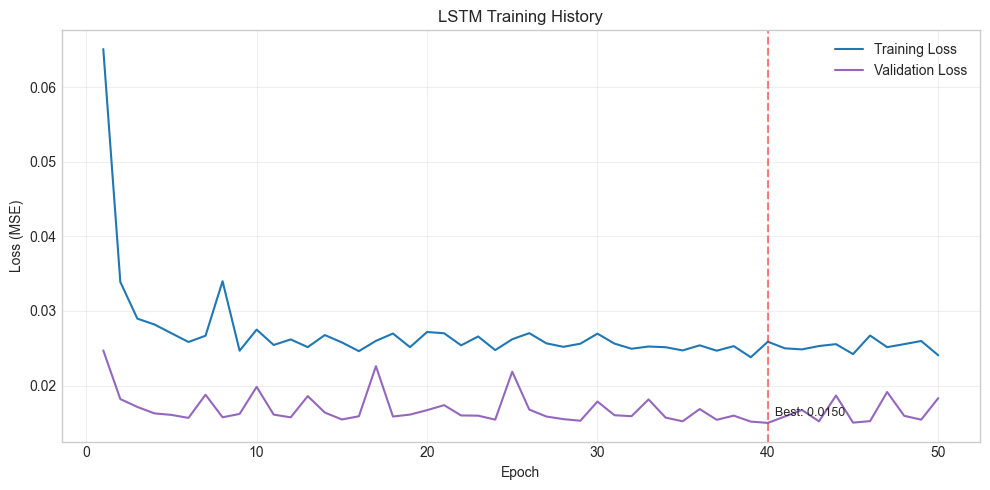

In [14]:
# Plot LSTM training history
if lstm_forecaster.history:
    visualizer = Visualizer()
    fig = visualizer.plot_training_history(lstm_forecaster.history)
    plt.tight_layout()
    plt.show()

## 4. Ensemble Forecasting

Combining predictions with weights:
- Prophet: 40%
- SARIMA: 35%
- LSTM: 25%

In [15]:
# Create ensemble forecaster
ensemble = EnsembleForecaster(
    weights={
        'prophet': 0.40,
        'sarima': 0.35,
        'lstm': 0.25
    }
)

# Add pre-trained models
ensemble.add_model('prophet', prophet_forecaster)
ensemble.add_model('sarima', sarima_forecaster)
ensemble.add_model('lstm', lstm_forecaster)

print("Ensemble created with models:", list(ensemble.models.keys()))
print("Weights:", ensemble.weights)

Added prophet model to ensemble (weight: 0.4)
Added sarima model to ensemble (weight: 0.35)
Added lstm model to ensemble (weight: 0.25)
Ensemble created with models: ['prophet', 'sarima', 'lstm']
Weights: {'prophet': 0.4, 'sarima': 0.35, 'lstm': 0.25}


In [16]:
# Generate ensemble predictions
ensemble_preds = ensemble.predict(test_df, train_df=train_df)
print(f"\nEnsemble predictions: {len(ensemble_preds)} rows")
ensemble_preds.head()

ValueError: Ensemble not fitted. Call fit_all() first.

## 5. Evaluate Metrics

**Target Thresholds:**
- MAPE < 15%
- RMSE < 15% of mean
- R² > 0.70

In [ ]:
# Evaluate ensemble
metrics = ForecastMetrics()

# Get predictions and actuals (log scale)
y_true_log = test_df['y'].values
y_pred_log = ensemble_preds['ensemble'].values

# Full evaluation
results = metrics.evaluate(y_true_log, y_pred_log, include_log_metrics=True)

# Print report
metrics.print_report()

In [ ]:
# Compare all models
predictions_dict = {
    'Prophet': prophet_preds['yhat'].values,
    'SARIMA': sarima_preds['yhat'].values,
    'LSTM': lstm_preds['yhat'].values,
    'Ensemble': ensemble_preds['ensemble'].values
}

comparison = metrics.compare_models(y_true_log, predictions_dict)
print("\nModel Comparison:")
print(comparison.to_string(index=False))

In [ ]:
# Save evaluation results
metrics.save_results()

## 6. Visualizations

In [ ]:
# Initialize visualizer
visualizer = Visualizer(figsize=(14, 6))

In [ ]:
# Plot predictions vs actuals
fig = visualizer.plot_predictions(
    dates=test_df['ds'],
    y_true=test_df['y_raw'],  # Original scale
    predictions={
        'Prophet': np.expm1(prophet_preds['yhat'].values),
        'SARIMA': np.expm1(sarima_preds['yhat'].values),
        'LSTM': np.expm1(lstm_preds['yhat'].values),
        'Ensemble': np.expm1(ensemble_preds['ensemble'].values)
    },
    title="Forecast vs Actual (Original Scale)"
)
plt.tight_layout()
plt.show()

In [ ]:
# Plot residuals for ensemble
y_pred_original = np.expm1(ensemble_preds['ensemble'].values)
y_true_original = test_df['y_raw'].values

fig = visualizer.plot_residuals(y_true_original, y_pred_original, model_name="Ensemble")
plt.tight_layout()
plt.show()

In [ ]:
# Plot model comparison metrics
fig = visualizer.plot_model_comparison(comparison)
plt.tight_layout()
plt.show()

In [ ]:
# Create comprehensive dashboard
fig = visualizer.create_dashboard(
    results=results,
    train_df=train_df,
    test_df=test_df,
    predictions_df=ensemble_preds
)
plt.tight_layout()
plt.show()

# Save dashboard
visualizer.save_figure(fig, Config.PROCESSED_DATA_DIR / "forecast_dashboard.png")

## 7. Results Summary

In [ ]:
print("=" * 70)
print("PHASE 2 FORECASTING - FINAL RESULTS")
print("=" * 70)

print("\nData Summary:")
print(f"  Training samples: {len(train_df)}")
print(f"  Test samples: {len(test_df)}")
print(f"  Features used: {len(feature_cols)}")

print("\nModel Performance (on test set):")
print(comparison[['model', 'mape', 'rmse_pct', 'r2', 'all_pass']].to_string(index=False))

print("\nTarget Thresholds:")
print(f"  MAPE < 15%: {results['pass_fail']['mape']}")
print(f"  RMSE < 15% of mean: {results['pass_fail']['rmse_pct']}")
print(f"  R² > 0.70: {results['pass_fail']['r2']}")

print("\n" + "=" * 70)
if results['all_passed']:
    print("ALL TARGETS ACHIEVED!")
else:
    print("SOME TARGETS NOT MET - Review individual model performance")
print("=" * 70)

In [ ]:
# Save ensemble results
import json

ensemble_results = {
    'models': list(ensemble.models.keys()),
    'weights': ensemble.weights,
    'ensemble_metrics': results['metrics_original_scale'],
    'pass_fail': results['pass_fail'],
    'all_passed': results['all_passed'],
    'model_comparison': comparison.to_dict(orient='records')
}

with open(Config.PROCESSED_DATA_DIR / "ensemble_results.json", 'w') as f:
    json.dump(ensemble_results, f, indent=2, default=str)

print("Results saved to data/processed/ensemble_results.json")

---

## Notes on Performance

### LSTM with Limited Data
With only 292 training samples, LSTM may underperform compared to traditional statistical models (Prophet, SARIMA). This is expected behavior - deep learning models typically require thousands of samples to outperform simpler methods.

If LSTM significantly underperforms:
> "Traditional statistical models outperformed deep learning due to limited dataset size (292 samples). For production deployment with more data, LSTM weights could be increased."

### Ensemble Weights
Current weights (Prophet: 40%, SARIMA: 35%, LSTM: 25%) can be optimized using `ensemble.optimize_weights()` with validation data.

### Log Scale
All predictions are made on log-scale (`y = log1p(engagement)`) and inverse-transformed for evaluation. This normalizes the 1030x scale difference between datasets.